Import Required Libraries

In [ ]:
import tensorflow as tf
import os
import random
import numpy as np
import pickle

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
# from segmentation_models.losses import bce_jaccard_loss
# from segmentation_models.metrics import iou_score

Load in the dataset

In [2]:
X_train= pickle.load(open("Datasets/augmented/X_train.pickle","rb"))
Y_train = pickle.load(open("Datasets/augmented/y_train.pickle","rb"))

Plot sample Images and Masks for Confirmation

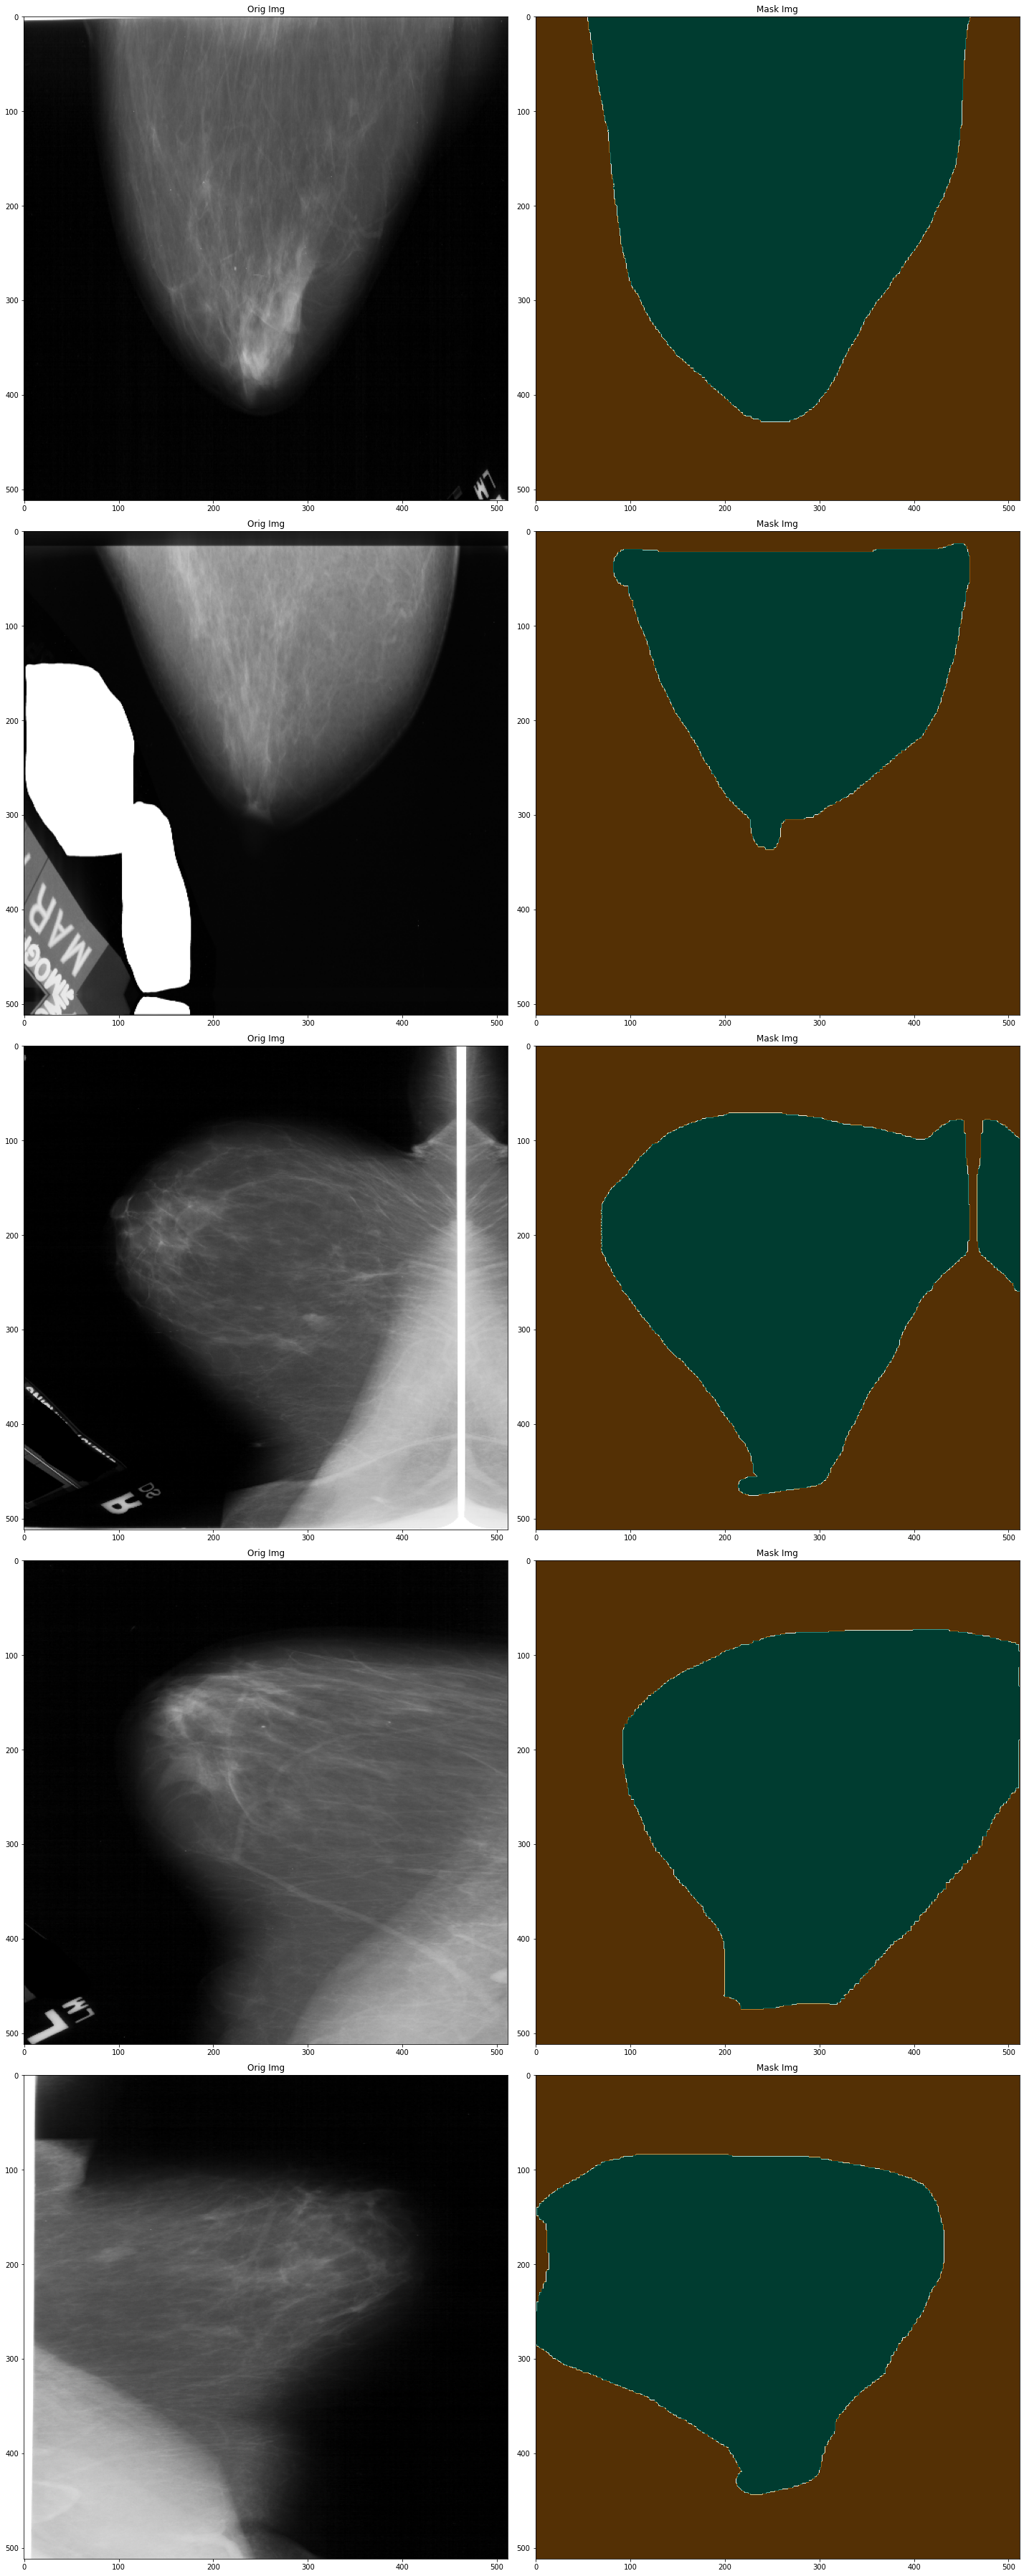

In [3]:
fig=plt.figure(figsize=(20,50))
rows = 5
columns = 2
i=0
for image,mask in zip(X_train[0:5],Y_train[0:5]):
    i+=1
    fig.add_subplot(rows, columns, i)
    plt.imshow(image )
    plt.title("Orig Img")
    i+=1
    fig.add_subplot(rows, columns, i)
    plt.imshow(mask, cmap='BrBG' )
    plt.title("Mask Img")
    fig.tight_layout(pad=1)

Build the Model

In [8]:
IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 3


#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',iou_score])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 512, 512, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 512, 512, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

In [ ]:
#Modelcheckpoint
NAME= 'UNET_MODEL_1'
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=20, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir=f'DeepModels/{NAME}'),
        tf.keras.callbacks.ModelCheckpoint(f'ModelCheckPoints/{NAME}.h5', verbose=1, save_best_only=True)]

results = model.fit(X_train, Y_train, validation_split=0.2, batch_size=10, epochs=50, callbacks=[callbacks])

Epoch 1/50


In [3]:
import pickle
import cv2
from tensorflow.keras.models import load_model
####################################
model=load_model('ModelCheckPoints/UNET_MODEL_1.h5')
X_test= pickle.load(open("Datasets/augmented/X_test.pickle","rb"))
Y_test = pickle.load(open("Datasets/augmented/Y_test.pickle","rb"))

In [4]:
_,acc=model.evaluate(X_test,Y_test)
print("Accuracy= ",(acc*100.0),"%")

7/7 [==============================] - 12s 574ms/step - loss: 0.0845 - accuracy: 0.9732
Accuracy=  97.32102751731873 %


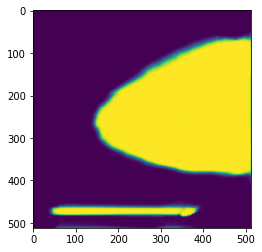

In [5]:
import matplotlib.pyplot as plt
y_pred=model.predict(X_test)
plt.imshow(y_pred[0])
plt.show()

In [22]:
import random
import numpy as np
idx = random.randint(0, len(X_test))

testImage=X_test[idx]
testImage=np.expand_dims(testImage, axis=0)
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_test[:int(X_test.shape[0]*0.9)], verbose=1)
preds_test = model.predict(testImage, verbose=1)
#
#
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)
#
#

21/23 [==========================>...] - ETA: 0s

ResourceExhaustedError:  OOM when allocating tensor with shape[32,32,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model/concatenate_3/concat (defined at C:\Users\moham\AppData\Local\Temp/ipykernel_10344/649573606.py:2) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_predict_function_2154]

Function call stack:
predict_function


In [ ]:
ix = random.randint(0, len(preds_test_t)-1)
# # Perform a sanity check on some random training samples
fig = plt.figure(figsize=(30,30))
ax1 = fig.add_subplot(2,3,1)
ax1.imshow(X_train[ix])
ax2 = fig.add_subplot(2,3,2)
ax2.imshow(Y_train[ix])
ax2 = fig.add_subplot(2,3,3)
ax2.imshow(preds_train_t[ix])
#

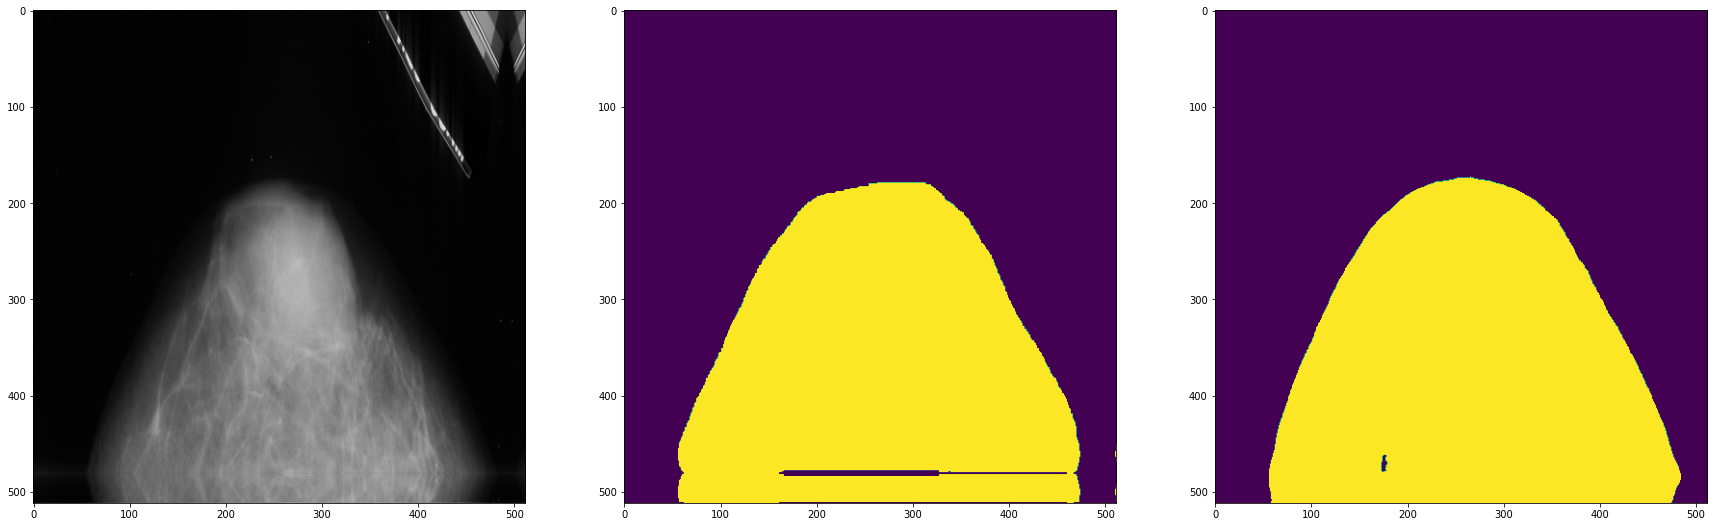

In [19]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_test_t))
fig = plt.figure(figsize=(30,30))
ax1=fig.add_subplot(2,3,1)
ax1.imshow(X_test[idx])
ax2=fig.add_subplot(2,3,2)
ax2.imshow(Y_test[idx])
ax3=fig.add_subplot(2,3,3)
ax3.imshow(preds_test_t[ix])
